In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
import cv2 
from tensorflow.keras import activations
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.xception import Xception
from sklearn.metrics import classification_report 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

In [64]:
import os


In [5]:
data_dir="C:\\Users\\djroc\\Dropbox\\My PC (LAPTOP-8JC4NERN)\\Downloads\\Face mask"

In [6]:
os.listdir(data_dir)

['actual test', 'actual train', 'Train']

In [7]:
train_path=data_dir+'\\Train\\'

In [8]:
print(len(os.listdir(train_path+'with_mask')))
print(len(os.listdir(train_path+'without_mask')))

3725
3828


In [10]:
#We are taking 1000 masked images from the train directory and storing the images in actual train directory
import cv2 
count=0
for image_filename in os.listdir(train_path+'with_mask'):
    path = r'C:\\Users\\djroc\\Dropbox\\My PC (LAPTOP-8JC4NERN)\\Downloads\\Face mask\\Train\\with_mask\\{}'.format(image_filename)
    directory = r'C:\\Users\\djroc\\Dropbox\\My PC (LAPTOP-8JC4NERN)\\Downloads\\Face mask\\actual train\\masked'
    img = cv2.imread(path) 
    os.chdir(directory) 
    filename = image_filename
    cv2.imwrite(filename, img) 
    if count>998:
        break
    count=count+1

In [11]:
#We are taking 1000 unmasked images from the train directory and storing the images in actual train directory
count=0
for image_filename in os.listdir(train_path+'without_mask'):
    path = r'C:\\Users\\djroc\\Dropbox\\My PC (LAPTOP-8JC4NERN)\\Downloads\\Face mask\\Train\\without_mask\\{}'.format(image_filename)
    directory = r'C:\\Users\\djroc\\Dropbox\\My PC (LAPTOP-8JC4NERN)\\Downloads\\Face mask\\actual train\\unmasked'
    img = cv2.imread(path) 
    os.chdir(directory) 
    filename = image_filename
    cv2.imwrite(filename, img) 
    if count>998:
        break
    count=count+1

In [9]:
actual_train=data_dir+'\\actual train\\'
actual_test=data_dir+'\\actual test\\'

In [10]:
os.listdir(actual_train)

['masked', 'unmasked']

In [11]:
masked=actual_train+'masked\\'+os.listdir(actual_train+'masked')[0]

In [12]:
masked

'C:\\Users\\djroc\\Dropbox\\My PC (LAPTOP-8JC4NERN)\\Downloads\\Face mask\\actual train\\masked\\with_mask_1.jpg'

In [13]:
from matplotlib.image import imread

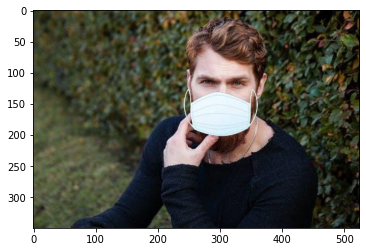

In [14]:
plt.imshow(imread(masked))

In [15]:
unmasked=actual_train+'unmasked\\'+os.listdir(actual_train+'unmasked')[0]

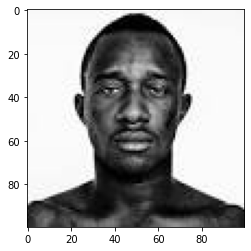

In [16]:
plt.imshow(imread(unmasked))

In [17]:
print(len(os.listdir(actual_train+'masked')))
print(len(os.listdir(actual_train+'unmasked')))

1000
1000


In [18]:
#We are stroing the 1st and 2nd dimensions of masked into the dim1_mask and dim2_mask list
dim1_mask=[]
dim2_mask=[]
for image_filename in os.listdir(actual_train+'masked'):
    if (image_filename!='Thumbs.db'):
            img = imread(actual_train+'masked\\'+image_filename)
            d1,d2,colors=img.shape
            dim1_mask.append(d1)
            dim2_mask.append(d2)

In [19]:
print(dim1_mask[0:4])
print(dim2_mask[0:4])

[350, 218, 105, 403]
[525, 135, 86, 310]


In [20]:
#We are calculating the mean dimensions of the masked images
mask_img_shape=(np.mean(dim1_mask),np.mean(dim2_mask),colors)

In [21]:
#We are stroing the 1st and 2nd dimensions of masked into the dim1_mask and dim2_mask list
dim1_withoutmask=[]
dim2_withoutmask=[]
for image_filename in os.listdir(actual_train+'unmasked'):
    if (image_filename!='Thumbs.db'):
            img = imread(actual_train+'unmasked\\'+image_filename)
            d1,d2,colors=img.shape
            dim1_withoutmask.append(d1)
            dim2_withoutmask.append(d2)

In [22]:
#We are calculating the mean dimensions of the unmasked images
without_mask_img_shape=(np.mean(dim1_mask),np.mean(dim2_mask),colors)

In [23]:
mask_img_shape,without_mask_img_shape

((283.808, 227.135, 3), (283.808, 227.135, 3))

In [24]:
#Traget image shape
img_shape=img_shape=(283,227,3)

In [25]:
#We are using ImageDataGenerator which generates copies of the image with transormations like rescaling,rotations,zooming,flips,shearing etc.
img_gen=ImageDataGenerator(rescale=1.0/255,rotation_range=20,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,
                          horizontal_flip=True,vertical_flip=True,fill_mode='nearest')

In [26]:
train_img_gen=img_gen.flow_from_directory(actual_train,target_size=img_shape[0:2],batch_size=100,shuffle=True,
                             class_mode='categorical')

Found 2000 images belonging to 2 classes.


In [27]:
test_img_gen=img_gen.flow_from_directory(actual_test,target_size=img_shape[0:2],batch_size=1,shuffle=False,
                             class_mode='categorical')

Found 20 images belonging to 2 classes.


In [28]:
# We are loading the MobileNetV2 network,and removing the head FC layer by making include_top=False
#Then we are making layer.trainable = False so that layers of MobileNetV2 model are not trained again
mobilenet = MobileNetV2(weights='imagenet',include_top=False,input_shape=(283,227,3))
for layer in mobilenet.layers:
    layer.trainable = False
model = Sequential()
model.add(mobilenet)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 62720)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 125442    
Total params: 2,383,426
Trainable params: 125,442
Non-trainable params: 2,257,984
_________________________________________________________________


In [29]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
history = model.fit_generator(generator=train_img_gen,epochs=10)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
20/20 [==============================] - 32s 2s/step - loss: 0.4580 - accuracy: 0.8170
Epoch 2/10
20/20 [==============================] - 32s 2s/step - loss: 0.4086 - accuracy: 0.9455
Epoch 3/10
20/20 [==============================] - 33s 2s/step - loss: 0.3902 - accuracy: 0.9630
Epoch 4/10
20/20 [==============================] - 32s 2s/step - loss: 0.3973 - accuracy: 0.9565
Epoch 5/10
20/20 [==============================] - 32s 2s/step - loss: 0.4155 - accuracy: 0.9590
Epoch 6/10
20/20 [==============================] - 33s 2s/step - loss: 0.4124 - accuracy: 0.9625
Epoch 7/10
20/20 [==============================] - 36s 2s/step - loss: 0.3885 - accuracy: 0.9710
Epoch 8/10
20/20 [==============================] - 33s 2s/step - loss: 0.4120 - accuracy: 0.9640
Epoch 9/10
20/20 [==============================] - 33s 2s/step - loss: 0.3651 - accuracy: 0.9830
Epoch 10/10
20/20 [=======================

In [30]:
model.evaluate_generator(test_img_gen)

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.6868423223495483, 0.6499999761581421]

In [31]:
test_img_gen.class_indices

{'masked': 0, 'unmasked': 1}

In [32]:
predictions=model.predict(test_img_gen)

In [33]:
predictions=np.argmax(np.round(predictions),axis=1)

In [34]:
test_img_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
predictions

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [36]:

print(classification_report(test_img_gen.classes,predictions))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



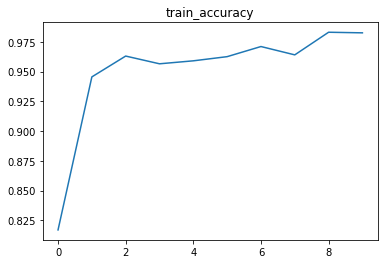

In [37]:
plt.figure()
train_accuracy=history.history['accuracy']
epochs=range(len(train_accuracy))
plt.plot(epochs,train_accuracy)
plt.title('train_accuracy')
plt.show()

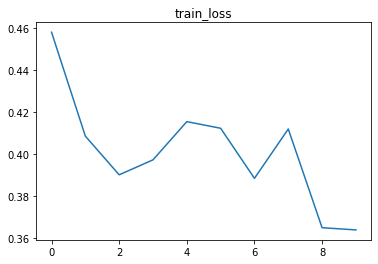

In [38]:
train_loss=history.history['loss']
plt.plot(epochs,train_loss,label='train_loss')
plt.title('train_loss')
plt.show()

In [39]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

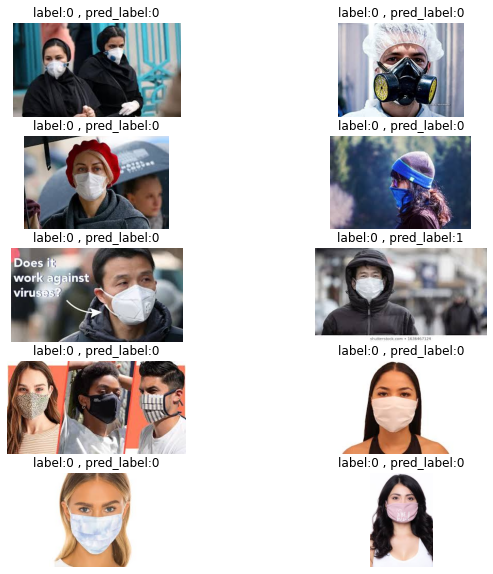

In [40]:
plt.figure(figsize=(10,10))
j=0
for i in range(0,10):
    plt.subplot(5,2,i+1)
    img_path=actual_test+'masked\\'+os.listdir(actual_test+'masked')[i]
    plt.imshow(imread(img_path))
    plt.title("label:{} , pred_label:{}".format(0,predictions[j]))
    j=j+1
    plt.axis('off')

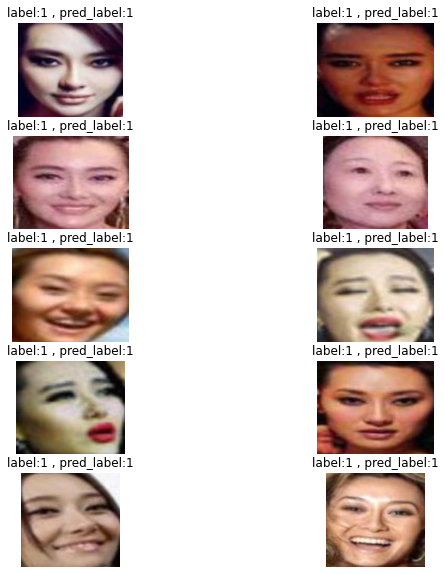

In [41]:
plt.figure(figsize=(10,10))
j=10
for i in range(0,10):
    plt.subplot(5,2,i+1)
    img_path=actual_test+'unmasked\\'+os.listdir(actual_test+'unmasked')[i]
    plt.imshow(imread(img_path))
    plt.title("label:{} , pred_label:{}".format(1,predictions[j]))
    j=j+1
    plt.axis('off')

In [42]:
# We are loading the InceptionV3 network,and removing the head FC layer by making include_top=False
#Then we are making layer.trainable = False so that layers of InceptionV3 model are not trained again
inception = InceptionV3(weights='imagenet',include_top=False,input_shape=(283,227,3))
for layer in inception.layers:
    layer.trainable = False
model_inception = Sequential()
model_inception.add(inception)
model_inception.add(Flatten())
model_inception.add(Dense(2,activation='sigmoid'))
model_inception.summary()
    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 102402    
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


In [43]:
model_inception.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
history_inception = model_inception.fit_generator(generator=train_img_gen,epochs=10)

Epoch 1/10
20/20 [==============================] - 46s 2s/step - loss: 0.5342 - accuracy: 0.8205
Epoch 2/10
20/20 [==============================] - 55s 3s/step - loss: 0.4202 - accuracy: 0.9250
Epoch 3/10
20/20 [==============================] - 53s 3s/step - loss: 0.4116 - accuracy: 0.9450
Epoch 4/10
20/20 [==============================] - 53s 3s/step - loss: 0.3836 - accuracy: 0.9390
Epoch 5/10
20/20 [==============================] - 53s 3s/step - loss: 0.3882 - accuracy: 0.9410
Epoch 6/10
20/20 [==============================] - 49s 2s/step - loss: 0.3858 - accuracy: 0.9490
Epoch 7/10
20/20 [==============================] - 48s 2s/step - loss: 0.3800 - accuracy: 0.9565
Epoch 8/10
20/20 [==============================] - 47s 2s/step - loss: 0.3995 - accuracy: 0.9485
Epoch 9/10
20/20 [==============================] - 49s 2s/step - loss: 0.3841 - accuracy: 0.9470
Epoch 10/10
20/20 [==============================] - 48s 2s/step - loss: 0.3831 - accuracy: 0.9560


In [44]:
predictions_inception=model_inception.predict(test_img_gen)

In [45]:
predictions_inception=np.argmax(np.round(predictions_inception),axis=1)

In [46]:
test_img_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [47]:
predictions_inception

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [48]:

print(classification_report(test_img_gen.classes,predictions_inception))

              precision    recall  f1-score   support

           0       1.00      0.80      0.89        10
           1       0.83      1.00      0.91        10

    accuracy                           0.90        20
   macro avg       0.92      0.90      0.90        20
weighted avg       0.92      0.90      0.90        20



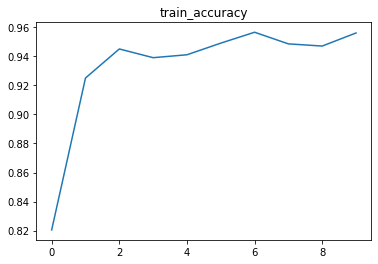

In [49]:
plt.figure()
train_accuracy=history_inception.history['accuracy']
epochs=range(len(train_accuracy))
plt.plot(epochs,train_accuracy)
plt.title('train_accuracy')
plt.show()

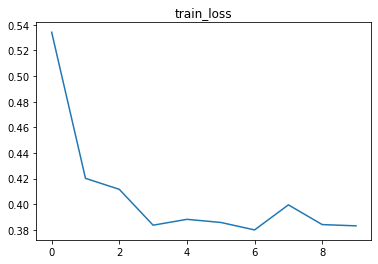

In [50]:
train_loss=history_inception.history['loss']
plt.plot(epochs,train_loss,label='train_loss')
plt.title('train_loss')
plt.show()

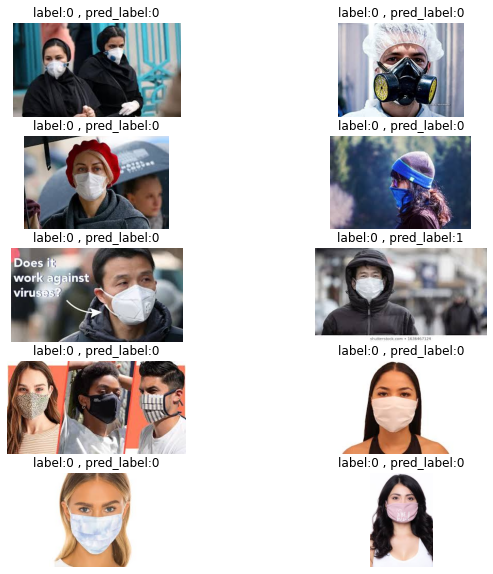

In [76]:
plt.figure(figsize=(10,10))
j=0
for i in range(0,10):
    plt.subplot(5,2,i+1)
    img_path=actual_test+'masked\\'+os.listdir(actual_test+'masked')[i]
    plt.imshow(imread(img_path))
    plt.title("label:{} , pred_label:{}".format(0,predictions[j]))
    j=j+1
    plt.axis('off')

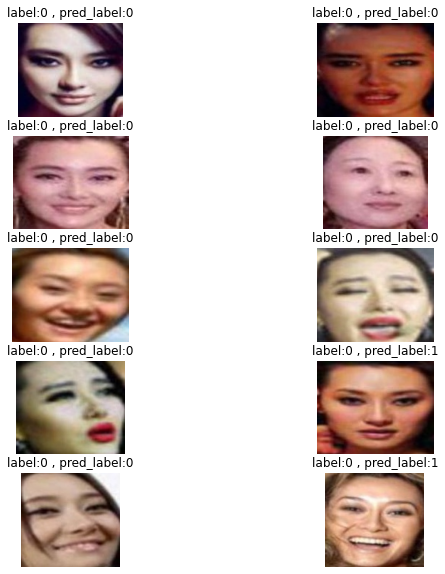

In [75]:
plt.figure(figsize=(10,10))
j=0
for i in range(0,10):
    plt.subplot(5,2,i+1)
    img_path=actual_test+'unmasked\\'+os.listdir(actual_test+'unmasked')[i]
    plt.imshow(imread(img_path))
    plt.title("label:{} , pred_label:{}".format(0,predictions_inception[j]))
    j=j+1
    plt.axis('off')

In [65]:
# We are loading the Xception network,and removing the head FC layer by making include_top=False
#Then we are making layer.trainable = False so that layers of Xception model are not trained again
xception = Xception(weights='imagenet',include_top=False,input_shape=(283,227,3))
for layer in xception.layers:
    layer.trainable = False
model_xception = Sequential()
model_xception.add(xception)
model_xception.add(Flatten())
model_xception.add(Dense(2,activation='sigmoid'))
model_xception.summary()

83689472/83683744 [==============================] - 31s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 200706    
Total params: 21,062,186
Trainable params: 200,706
Non-trainable params: 20,861,480
_________________________________________________________________


In [66]:
model_xception.compile(loss='categorical_crossentropy',optimizer=Adam(),metrics=['accuracy'])
history_xception = model_xception.fit_generator(generator=train_img_gen,epochs=10)

Epoch 1/10
20/20 [==============================] - 83s 4s/step - loss: 0.5184 - accuracy: 0.8540
Epoch 2/10
20/20 [==============================] - 83s 4s/step - loss: 0.2246 - accuracy: 0.9525
Epoch 3/10
20/20 [==============================] - 83s 4s/step - loss: 0.1207 - accuracy: 0.9740
Epoch 4/10
20/20 [==============================] - 84s 4s/step - loss: 0.1148 - accuracy: 0.9770
Epoch 5/10
20/20 [==============================] - 85s 4s/step - loss: 0.0897 - accuracy: 0.9810
Epoch 6/10
20/20 [==============================] - 85s 4s/step - loss: 0.0543 - accuracy: 0.9855
Epoch 7/10
20/20 [==============================] - 82s 4s/step - loss: 0.0887 - accuracy: 0.9840
Epoch 8/10
20/20 [==============================] - 81s 4s/step - loss: 0.0764 - accuracy: 0.9835
Epoch 9/10
20/20 [==============================] - 81s 4s/step - loss: 0.0510 - accuracy: 0.9855
Epoch 10/10
20/20 [==============================] - 81s 4s/step - loss: 0.0754 - accuracy: 0.9845


In [67]:
predictions_xception=model_xception.predict(test_img_gen)

In [68]:
predictions_xception=np.argmax(np.round(predictions_xception),axis=1)

In [69]:
test_img_gen.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [70]:
predictions_xception

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int64)

In [71]:
print(classification_report(test_img_gen.classes,predictions_xception))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.91      1.00      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20



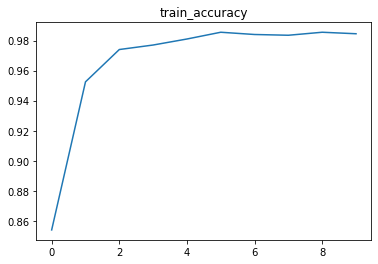

In [72]:
plt.figure()
train_accuracy=history_xception.history['accuracy']
epochs=range(len(train_accuracy))
plt.plot(epochs,train_accuracy)
plt.title('train_accuracy')
plt.show()

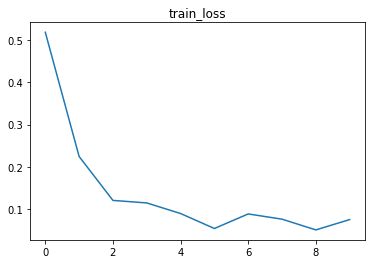

In [73]:
train_loss=history_xception.history['loss']
plt.plot(epochs,train_loss,label='train_loss')
plt.title('train_loss')
plt.show()

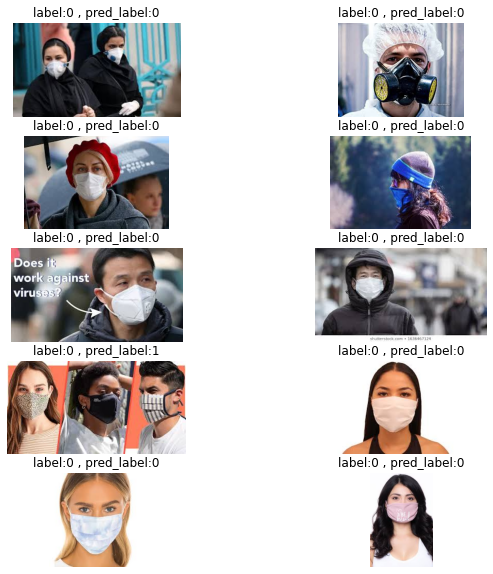

In [78]:
plt.figure(figsize=(10,10))
j=0
for i in range(0,10):
    plt.subplot(5,2,i+1)
    img_path=actual_test+'masked\\'+os.listdir(actual_test+'masked')[i]
    plt.imshow(imread(img_path))
    plt.title("label:{} , pred_label:{}".format(0,predictions_xception[j]))
    j=j+1
    plt.axis('off')

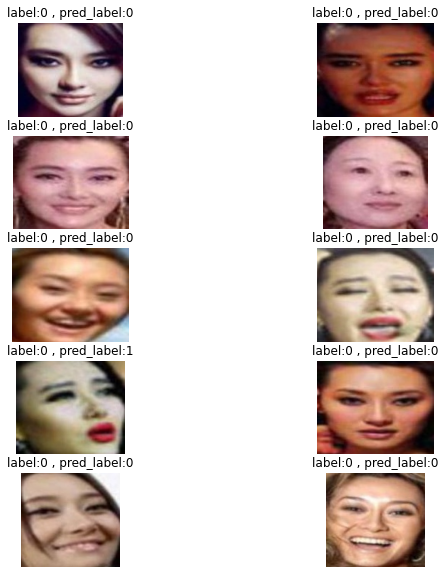

In [77]:
plt.figure(figsize=(10,10))
j=0
for i in range(0,10):
    plt.subplot(5,2,i+1)
    img_path=actual_test+'unmasked\\'+os.listdir(actual_test+'unmasked')[i]
    plt.imshow(imread(img_path))
    plt.title("label:{} , pred_label:{}".format(0,predictions_xception[j]))
    j=j+1
    plt.axis('off')